# DL Modeling
- Ignoring data before 2006.
- Using only type=5 examples.
- No feature selection.
- Param tuning.
- Added back removed features ['Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4'].
- Removed soil_data features.
- Shift features for 6 months before.
- Use fastai cathegorical feature functionalities.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os 

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from kdd_utils import addFieldDataFtrs, addSoilFtrs, cvPerYear

sns.set(style="whitegrid")

/home/eraldo/miniconda2/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
from fastai.structured import *
from fastai.column_data import *

/home/eraldo/miniconda2/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/eraldo/miniconda2/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Train and test datasets

Basic data containing palm tree information

In [4]:
path = '../input/'

# Train data.
df_train = pd.read_csv(os.path.join(path, 'train.csv'))

# Ignoring date before 2006 for training.
# df_train = df_train[df_train.harvest_year >= 2006]

# Using only examples with type=5 for training.
# df_train = df_train[df_train.type == 5]

# Test data.
df_test  = pd.read_csv(os.path.join(path, 'test.csv'))

# Merge train and test data for ease of pre-processing.
df_all = pd.concat([df_train, df_test], sort=False).reindex()

# Configure number of jobs.
N_JOBS=7

print('Shapes\n---\nTrain: {}\n Test: {}\n  All: {}'.format(df_train.shape, df_test.shape, df_all.shape))

Shapes
---
Train: (5243, 7)
 Test: (4110, 6)
  All: (9353, 7)


## Field and Soil Features

These files hold atmospheric data from January 2002 to December 2017, and can be used to estimate the weather conditions during the development of the plant. Notice that weather does influence the production. Using only a single month prior to harvest is probably too little data. Participants should decide how far back in the past they want to look when training models.



In [5]:
df_all_ftrs = addFieldDataFtrs(df_all, shiftPeriod=12, shiftFtrs=['temperature', 'dewpoint', 'windspeed', 
                                                                 'Precipitation', 'Soilwater_L1', 
                                                                 'Soilwater_L2', 'Soilwater_L3', 
                                                                 'Soilwater_L4'])
#df_all_ftrs = addSoilFtrs(df_all_ftrs)
print(list(df_all_ftrs.columns))

['index', 'Id', 'field', 'age', 'type', 'harvest_year', 'harvest_month', 'production', 'temperature', 'dewpoint', 'windspeed', 'Soilwater_L1', 'Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4', 'Precipitation', 'temperature_1', 'temperature_2', 'temperature_3', 'temperature_4', 'temperature_5', 'temperature_6', 'temperature_7', 'temperature_8', 'temperature_9', 'temperature_10', 'temperature_11', 'dewpoint_1', 'dewpoint_2', 'dewpoint_3', 'dewpoint_4', 'dewpoint_5', 'dewpoint_6', 'dewpoint_7', 'dewpoint_8', 'dewpoint_9', 'dewpoint_10', 'dewpoint_11', 'windspeed_1', 'windspeed_2', 'windspeed_3', 'windspeed_4', 'windspeed_5', 'windspeed_6', 'windspeed_7', 'windspeed_8', 'windspeed_9', 'windspeed_10', 'windspeed_11', 'Precipitation_1', 'Precipitation_2', 'Precipitation_3', 'Precipitation_4', 'Precipitation_5', 'Precipitation_6', 'Precipitation_7', 'Precipitation_8', 'Precipitation_9', 'Precipitation_10', 'Precipitation_11', 'Soilwater_L1_1', 'Soilwater_L1_2', 'Soilwater_L1_3', 'Soilwater_L1_4

In [6]:
df_all_ftrs.head()

,index,Id,field,age,type,harvest_year,harvest_month,production,temperature,dewpoint,...,Soilwater_L4_2,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11
0,0,0,0,19,5,2004,1,0.064071,26.132,24.661,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
1,1,1532,0,13,2,2004,1,0.283228,26.132,24.661,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
2,2,4204,0,4,5,2004,1,0.106263,26.132,24.661,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
3,3,1,0,19,5,2004,2,0.047658,25.295,24.401,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165
4,4,1533,0,13,2,2004,2,0.182068,25.295,24.401,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165


In [7]:
# Categorical features.
cat_ftrs = ['field', 'age', 'type', 'harvest_month']
# Continuous features.
contin_ftrs = [f for f in df_all_ftrs.columns if f not in (['production', 'Id', 'index'] + cat_ftrs)]
print(contin_ftrs)

['harvest_year', 'temperature', 'dewpoint', 'windspeed', 'Soilwater_L1', 'Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4', 'Precipitation', 'temperature_1', 'temperature_2', 'temperature_3', 'temperature_4', 'temperature_5', 'temperature_6', 'temperature_7', 'temperature_8', 'temperature_9', 'temperature_10', 'temperature_11', 'dewpoint_1', 'dewpoint_2', 'dewpoint_3', 'dewpoint_4', 'dewpoint_5', 'dewpoint_6', 'dewpoint_7', 'dewpoint_8', 'dewpoint_9', 'dewpoint_10', 'dewpoint_11', 'windspeed_1', 'windspeed_2', 'windspeed_3', 'windspeed_4', 'windspeed_5', 'windspeed_6', 'windspeed_7', 'windspeed_8', 'windspeed_9', 'windspeed_10', 'windspeed_11', 'Precipitation_1', 'Precipitation_2', 'Precipitation_3', 'Precipitation_4', 'Precipitation_5', 'Precipitation_6', 'Precipitation_7', 'Precipitation_8', 'Precipitation_9', 'Precipitation_10', 'Precipitation_11', 'Soilwater_L1_1', 'Soilwater_L1_2', 'Soilwater_L1_3', 'Soilwater_L1_4', 'Soilwater_L1_5', 'Soilwater_L1_6', 'Soilwater_L1_7', 'Soilwater_L1

In [8]:
# Remove unused features.
df_all_ftrs = df_all_ftrs[cat_ftrs + contin_ftrs + ['production']]
df_all_ftrs.head(2)

,field,age,type,harvest_month,harvest_year,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,...,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11,production
0,0,19,5,1,2004,26.132,24.661,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.064071
1,0,13,2,1,2004,26.132,24.661,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.283228


In [9]:
# Inform pandas which features are categorical ...
for v in cat_ftrs:
    df_all_ftrs[v] = df_all_ftrs[v].astype('category').cat.as_ordered()
# ... and which are continuous.
for v in contin_ftrs:
    df_all_ftrs[v] = df_all_ftrs[v].astype('float32')

df_all_ftrs.head(2)

,field,age,type,harvest_month,harvest_year,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,...,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11,production
0,0,19,5,1,2004.0,26.132,24.660999,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.064071
1,0,13,2,1,2004.0,26.132,24.660999,1.8766,0.35274,0.35192,...,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.314165,0.283228


In [10]:
# Get train data only.
df_all_ftrs = df_all_ftrs[~df_all_ftrs.production.isna()]

In [11]:
val_year = 2010

# Ignore training examples with type != 5
# df_all_ftrs = df_all_ftrs[(df_all_ftrs.type == 5) | (df_all_ftrs.harvest_year >= val_year)]

val_idx = np.flatnonzero(df_all_ftrs.harvest_year >= val_year)
print(len(val_idx))
print(len(df_all_ftrs))

1387
5243


In [12]:
df, y, nas, mapper = proc_df(df_all_ftrs, y_fld='production', do_scale=True)
df.head(2)

,field,age,type,harvest_month,harvest_year,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,...,Soilwater_L4_2,Soilwater_L4_3,Soilwater_L4_4,Soilwater_L4_5,Soilwater_L4_6,Soilwater_L4_7,Soilwater_L4_8,Soilwater_L4_9,Soilwater_L4_10,Soilwater_L4_11
0,1,17,7,1,-1.626713,-1.014467,0.894659,-0.616689,0.894475,0.896105,...,-0.117815,-0.128899,-0.137128,-0.144918,-0.144076,-0.142981,-0.137557,-0.12906,-0.117197,-0.101698
1,1,11,4,1,-1.626713,-1.014467,0.894659,-0.616689,0.894475,0.896105,...,-0.117815,-0.128899,-0.137128,-0.144918,-0.144076,-0.142981,-0.137557,-0.12906,-0.117197,-0.101698


In [13]:
cat_sz = [(c, len(df_all_ftrs[c].cat.categories)+1) for c in cat_ftrs]
print(cat_sz)
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
print(emb_szs)

[('field', 29), ('age', 29), ('type', 10), ('harvest_month', 13)]
[(29, 15), (29, 15), (10, 5), (13, 7)]


In [14]:
md = ColumnarModelData.from_data_frame(path, # path for data saving
                                       val_idx, # indexes of validation examples
                                       df, # training data
                                       y.astype(np.float32), # output variable
                                       cat_flds=cat_ftrs, # categorical features
                                       bs=16) # batch size

In [15]:
# dropout rate
dr = 0.3

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": 0.00, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [100, 100], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

In [20]:
m = md.get_learner(**learner_params)

 73%|███████▎  | 175/241 [00:01<00:00, 166.23it/s, loss=3.09]


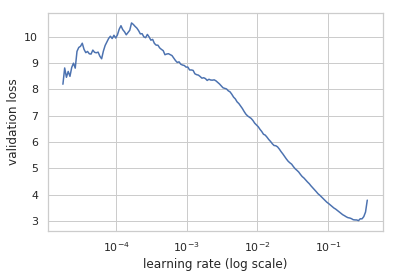

In [19]:
m.lr_find()
m.sched.plot()

In [22]:
lr = 1e-3
m.fit(lr, 15, cycle_len=2, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error         
    0      1.93272    0.319933   0.449537  
    1      1.285497   0.268722   0.411398                    
    2      0.521284   0.175805   0.335578                     
    3      0.356822   0.142494   0.303298                     
    4      0.211865   0.092935   0.241882                     
    5      0.181829   0.085164   0.231218                     
    6      0.107697   0.060041   0.192973                     
    7      0.084847   0.055395   0.184673                      
    8      0.058181   0.041755   0.157078                      
    9      0.047102   0.039632   0.152107                      
    10     0.035696   0.033489   0.137069                      
    11     0.035374   0.032067   0.133875                      
    12     0.026399   0.028661   0.122225                      
    13     0.023655   0.028153   0.12062                       
    14     0.020934   0.025714   0.112589                      
    1

[array([0.01914]), 0.09274386283662908]

In [23]:
lr = 1e-3
m.fit(lr, 15, cycle_len=2, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error           
    0      0.012627   0.018727   0.090602  
    1      0.01077    0.019088   0.091255                      
    2      0.011164   0.018364   0.090774                      
    3      0.012123   0.018252   0.089563                       
    4      0.010472   0.019622   0.092835                      
    5      0.010666   0.018232   0.090196                       
    6      0.010959   0.019455   0.092441                       
    7      0.010249   0.01829    0.089734                       
    8      0.008763   0.018743   0.089778                       
    9      0.008302   0.018507   0.089776                       
    10     0.010419   0.018922   0.089904                       
    11     0.00912    0.019567   0.092727                       
    12     0.008328   0.0216     0.096883                       
    13     0.008607   0.019532   0.093227                       
    14     0.00929    0.019912   0.094266         

[array([0.02121]), 0.09790715271178646]

In [24]:
lr = 1e-3
m.unfreeze()
m.fit(lr, 15, cycle_len=2, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error            
    0      0.006605   0.020258   0.094932  
    1      0.006542   0.020444   0.095186                       
    2      0.00743    0.020788   0.097337                       
    3      0.006407   0.021257   0.097852                       
    4      0.007936   0.021415   0.097857                       
    5      0.006866   0.021884   0.098371                       
    6      0.006866   0.021494   0.098585                       
    7      0.006071   0.021486   0.098603                       
    8      0.007069   0.02239    0.1                            
    9      0.005963   0.021289   0.098065                       
    10     0.006303   0.020949   0.096398                       
    11     0.006265   0.021396   0.097433                       
    12     0.007246   0.021724   0.098375                       
    13     0.004999   0.021551   0.098099                       
    14     0.005961   0.022007   0.098691     

[array([0.02243]), 0.09986286789780481]

 77%|███████▋  | 186/241 [00:01<00:00, 150.21it/s, loss=0.118]


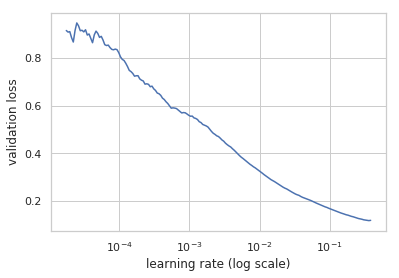

In [16]:
#m.summary()
m.lr_find()
m.sched.plot()

In [17]:
lr = 1e-3
m = md.get_learner(**learner_params)
m.fit(lr, 15, cycle_len=2, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error           
    0      0.078562   0.029219   0.128294  
    1      0.047318   0.025891   0.119237                      
    2      0.026524   0.026122   0.110701                      
    3      0.023688   0.024761   0.107807                      
    4      0.018294   0.024919   0.105941                      
    5      0.017209   0.025412   0.106981                      
    6      0.015993   0.023951   0.102854                      
    7      0.014526   0.023653   0.10236                       
    8      0.016301   0.023865   0.103798                      
    9      0.015868   0.02358    0.101793                      
    10     0.015411   0.022305   0.098339                      
    11     0.012596   0.023158   0.10092                       
    12     0.014002   0.023461   0.101213                      
    13     0.010754   0.023404   0.101319                      
    14     0.01237    0.022078   0.098384                   

[array([0.02067]), 0.09509397893284582]

In [30]:
m.fit(lr, 10, cycle_len=2, cycle_mult=2, metrics=[metrics.mean_absolute_error])

epoch      trn_loss   val_loss   mean_absolute_error           
    0      0.017292   0.02551    0.107972  
    1      0.017116   0.026397   0.1083                        
    2      0.017364   0.02733    0.109252                      
    3      0.01801    0.026482   0.108369                      
    4      0.01752    0.026552   0.108431                      
    5      0.017994   0.026314   0.108236                      
  0%|          | 0/241 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
m.fit(lr, 3, cycle_len=10, metrics=[metrics.mean_absolute_error])